In [1]:
!pip install pmdarima

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
import statsmodels.api as sm

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
# get train and test data for forecasting problem
def get_train_test_data(df, series, target, n_periods, input_periods, 
                        test_periods, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series (list of strings): column names in df
    target (string): target column name in df
    n_periods (int): total periods to extract
    input_periods (int): length of sequence input to network 
    test_periods (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: X_train, X_test_init, y_train, y_test     
    """
    
    # get arrays of predicting variables and target variable
    forecast_series = df[-(n_periods):][series].values
    forecast_target = df[-(n_periods):][target].values
    
    # split into train and test sets
    train_series = forecast_series[:-test_periods]
    train_target = forecast_target[:-test_periods]
    
    test_series = forecast_series[-test_periods:]
    test_target = forecast_target[-test_periods:]
    
    # populate train set with training samples of length input_periods
    X_train, y_train, X_test_init = [], [], []

    for i in range(0, train_series.shape[0] - input_periods, sample_gap): 
        X_train.append(train_series[i:i + input_periods]) # each training sample is of length input_periods
        y_train.append(train_target[i + input_periods]) # each y is just the next step after training sample

    for i in range(0, test_series.shape[0] - input_periods, sample_gap): 
        X_test_init.append(test_series[i:i + input_periods]) # each training sample is of length input_periods
        
    # The set that we had held out for testing (must be same length as original train input)
    y_test = test_target[input_periods:] # test_y is remaining values from test set
    
    # convert lists to arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test_init = np.array(X_test_init)
    y_test = np.array(y_test)
    
    return X_train, X_test_init, y_train, y_test

def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = np.copy(X_init).reshape(1,-1,1) 
    preds = []
    
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # 시퀀스의 첫번쨰 값을마지막값으로 대체 
        X_init[:,-1,:] = pred # 마지막 값을 모델에서 얻은 값으로 대체
    
    preds = np.array(preds)
    
    return preds.ravel()


In [5]:
from dateutil.relativedelta import relativedelta

In [6]:
# Read data on weather stations
df = pd.read_csv("서울강수량 분석(2013~2023).csv", encoding='cp949',index_col = 0)
df.head(20)


,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
일시,,,
2013-01-01,3.1,NaN,NaN
2013-01-11,0.0,NaN,NaN
2013-01-12,0.1,NaN,NaN
2013-01-16,0.3,NaN,NaN
2013-01-21,16.5,NaN,NaN
2013-01-22,0.5,NaN,NaN
2013-01-23,1.5,NaN,NaN
2013-01-24,0.1,NaN,NaN
2013-01-29,0.0,NaN,NaN


In [7]:
print(df.shape)

(1468, 3)


In [6]:
# 모든 열에서 NaN 값을 포함한 행을 제거
cleaned_data= df.dropna()

# 특정 열에서 NaN 값을 포함한 행을 제거
cleaned_data_specific_column = df.dropna(subset=['1시간최다강수량(mm)'])


NameError: name 'df' is not defined

In [5]:
cleaned_data_specific_column .head(30)


NameError: name 'cleaned_data_specific_column' is not defined

In [4]:
print(cleaned_data_specific_column.shape)

NameError: name 'cleaned_data_specific_column' is not defined

In [11]:
from sklearn.preprocessing import MinMaxScaler
# 사용할 열 선택
selected_column = "1시간최다강수량(mm)"
data = df[selected_column].values.reshape(-1, 1)

# 데이터 정규화 (0과 1 사이의 값으로 스케일 조정)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [41]:
# train/test split
X_train, X_test_init, y_train, y_test = get_train_test_data(cleaned_data_specific_column,
                                                           series = ['1시간최다강수량(mm)'], 
                                                           target = '1시간최다강수량(mm)', 
                                                           n_periods = 911, 
                                                           input_periods = 100, 
                                                           test_periods = 200, 
                                                           sample_gap = 1)

In [42]:
# get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# check shape
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test_init.shape)
print(y_test.shape)

(549, 100, 1)
(549,)
(62, 100, 1)
(62,)
(100, 100, 1)
(100,)


In [45]:
# parameters
epochs = 100
batch = 256
lr = 0.0003
adam = Adam(lr)

In [46]:
# define LSTM model
model_lstm_r = Sequential()
model_lstm_r.add(LSTM(70, input_shape = (X_train.shape[1], 1)))
model_lstm_r.add(Dense(1))
model_lstm_r.compile(loss = 'mse', optimizer = adam)
model_lstm_r.summary()
# fit model
lstm_r_hist1 = model_lstm_r.fit(X_train, y_train, epochs = epochs, batch_size = batch,
                                validation_data = (X_val, y_val), shuffle = True, verbose = 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 70)                20160     
                                                                 
 dense_5 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 8s 863ms/step - loss: 31.4656 - val_loss: 15.5033
Epoch 2/100
3/3 [==============================] - 1s 262ms/step - loss: 30.7400 - val_loss: 15.0227
Epoch 3/100
3/3 [==============================] - 1s 245ms/step - loss: 30.0319 - val_loss: 14.5632
Epoch 4/100
3/3 [==============================] - 1s 230ms/step - loss: 29.3595 - val_loss: 14.1257
Epoch 5/10

Text(0.5, 1.0, 'Loss over iterations for LSTM model')

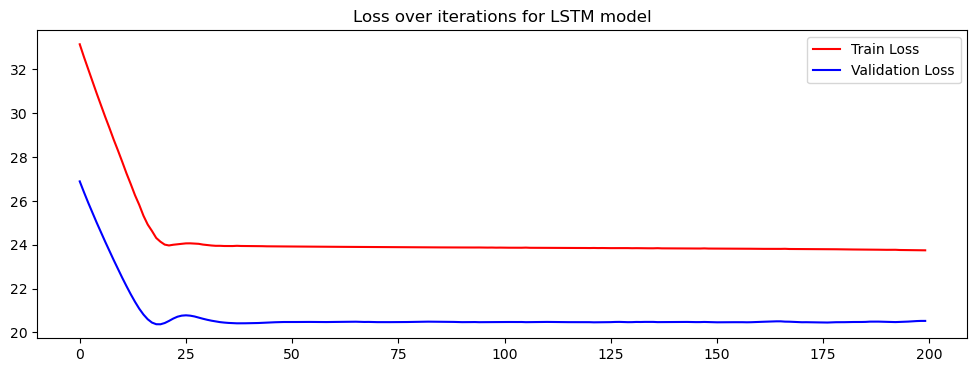

In [15]:
# plot Loss
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(range(len(lstm_r_hist1.history["loss"])), (lstm_r_hist1.history["loss"]),'r-', label = "Train Loss")
ax.plot(range(len(lstm_r_hist1.history["val_loss"])), (lstm_r_hist1.history["val_loss"]),'b-', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations for LSTM model')

In [138]:
# 평가 지표 계산 (여기서는 평균 제곱 오차를 사용하였습니다)
mse =  model_lstm_r.evaluate(X_val, y_val, verbose=0)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4.850879669189453


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 42ms/step
100


Text(0.5, 1.0, 'Predicted by LSTM vs True values for Rainfall')

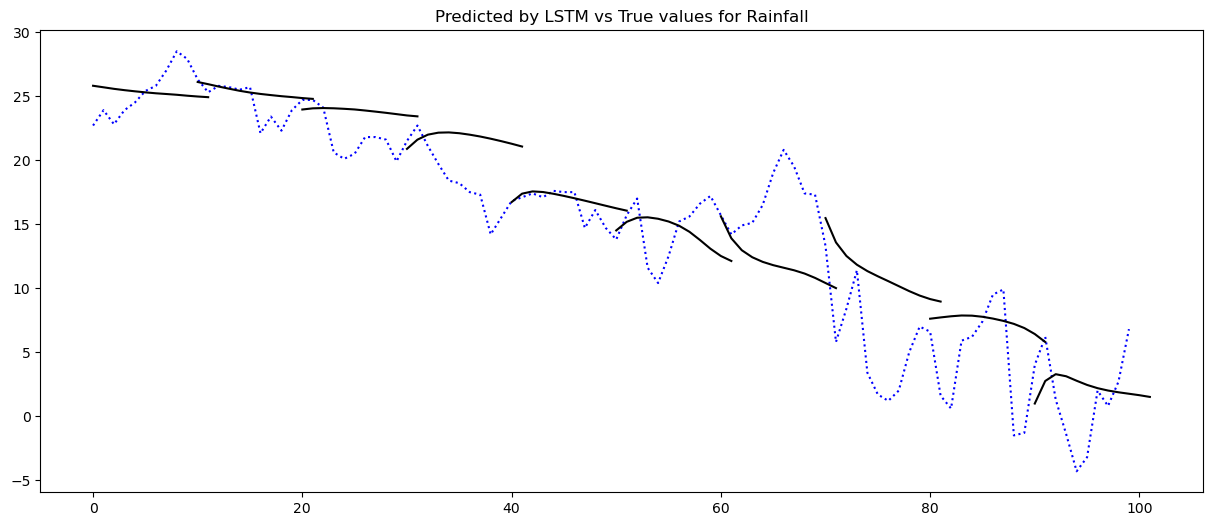

In [147]:
# for each sample in X_test_init predict 911 days of rainnfall 
y_preds_lstm_r = []

for i in range(len(X_test_init)):
    pred = predict(X_test_init[i], 12, model_lstm_r)
    y_preds_lstm_r.append(pred)
    
# plot predicted and true values
n = len(y_preds_lstm_r)
print(len(y_preds_lstm_r))

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(range(n), y_test,'b:', label = 'Original')
for i in range(0, n, 10):
    ax.plot(range(i, len(y_preds_lstm_r[i]) + i), y_preds_lstm_r[i],'k-', label = 'Predicted')
ax.set_title('Predicted by LSTM vs True values for Rainfall')

# 기온예측

In [103]:
# Read data on weather stations
df = pd.read_csv("서울기온분석.csv", encoding='cp949',index_col = 0)
df.head(20)


,평균기온(℃),최고기온(℃),최고기온시각,최저기온(℃),최저기온시각,일교차,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
일시,,,,,,,,,,,,
2013-01-01,-4.7,0.0,14:29,-8.7,5:48,8.7,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,-11.7,-4.8,0:01,-15.1,23:58,10.3,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-13.2,-9.3,15:43,-16.4,5:23,7.1,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,-10.7,-5.8,14:24,-14.8,7:05,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,-7.0,-1.2,14:18,-12.1,4:40,10.9,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,-6.3,-2.0,15:00,-9.4,7:45,7.4,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,-5.1,0.1,14:02,-8.8,5:09,8.9,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,-4.6,-0.7,15:00,-6.8,23:52,6.1,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,-9.0,-6.4,14:53,-10.7,23:29,4.3,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# 제거할 열들의 이름
columns_to_remove = ["최고기온(℃)", "최고기온시각","최저기온(℃)", "최저기온시각" , "일교차"]

# 열들 제거
df = df.drop(columns=columns_to_remove)

# 열이 제거된 데이터프레임 출력
df.head(10)

,평균기온(℃),Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
일시,,,,,,,
2013-01-01,-4.7,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,-11.7,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-13.2,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,-10.7,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,-7.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,-6.3,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,-5.1,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,-4.6,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,-9.0,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
temp_seoul= df
print(temp_seoul.shape)

(3991, 7)


In [178]:
# train/test split
X_train, X_test_init, y_train, y_test = get_train_test_data(temp_seoul,
                                                           series = ['평균기온(℃)'], 
                                                           target = '평균기온(℃)', 
                                                           n_periods = 3991, 
                                                           input_periods = 100, 
                                                           test_periods = 200, 
                                                           sample_gap = 1)

In [179]:
# get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# check shape
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test_init.shape)
print(y_test.shape)

(2583, 100, 1)
(2583,)
(1108, 100, 1)
(1108,)
(100, 100, 1)
(100,)


In [181]:
# parameters
epochs = 200
batch = 256
lr = 0.0003
adam = Adam(lr)

In [182]:
# define RNN model
model_rnn_t = Sequential()
model_rnn_t.add(SimpleRNN(200, input_shape = (X_train.shape[1], 1)))
model_rnn_t.add(Dropout(0.5))
model_rnn_t.add(Dense(1))
model_rnn_t.compile(loss = 'mse', optimizer = adam)
model_rnn_t.summary()

# fit model
rnn_t_hist1 = model_rnn_t.fit(X_train, y_train, epochs = epochs, batch_size = batch, 
                              validation_data = (X_val, y_val), shuffle = True, verbose = 1)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 200)               40400     
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                                 
Total params: 40601 (158.60 KB)
Trainable params: 40601 (158.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
11/11 [==============================] - 6s 267ms/step - loss: 257.9015 - val_loss: 214.9782
Epoch 2/200
11/11 [==============================] - 2s 202ms/step - loss: 190.8596 - val_loss: 159.8542
Epoch 3/200
11/11 [==============================] - 2s 196ms/step - 

Epoch 152/200
11/11 [==============================] - 2s 199ms/step - loss: 6.5483 - val_loss: 5.3860
Epoch 153/200
11/11 [==============================] - 2s 204ms/step - loss: 6.6604 - val_loss: 5.3290
Epoch 154/200
11/11 [==============================] - 2s 202ms/step - loss: 6.7320 - val_loss: 5.4190
Epoch 155/200
11/11 [==============================] - 2s 203ms/step - loss: 6.5831 - val_loss: 5.3823
Epoch 156/200
11/11 [==============================] - 2s 197ms/step - loss: 6.5765 - val_loss: 5.3756
Epoch 157/200
11/11 [==============================] - 2s 200ms/step - loss: 6.1721 - val_loss: 5.3489
Epoch 158/200
11/11 [==============================] - 2s 197ms/step - loss: 6.4831 - val_loss: 5.4993
Epoch 159/200
11/11 [==============================] - 2s 191ms/step - loss: 6.6282 - val_loss: 5.4046
Epoch 160/200
11/11 [==============================] - 2s 197ms/step - loss: 6.6196 - val_loss: 5.6042
Epoch 161/200
11/11 [==============================] - 2s 220ms/step - lo

Text(0.5, 1.0, 'Loss over iterations for RNN model')

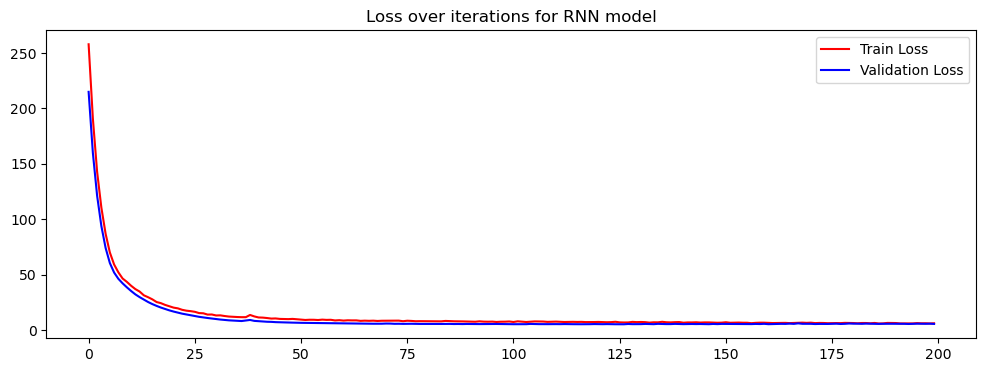

In [183]:
# plot Loss
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(range(len(rnn_t_hist1.history["loss"])), (rnn_t_hist1.history["loss"]),'r-', label = "Train Loss")
ax.plot(range(len(rnn_t_hist1.history["val_loss"])), (rnn_t_hist1.history["val_loss"]),'b-', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations for RNN model')

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 65ms/step


Text(0.5, 1.0, 'Predicted by RNN vs True values for Temperature')

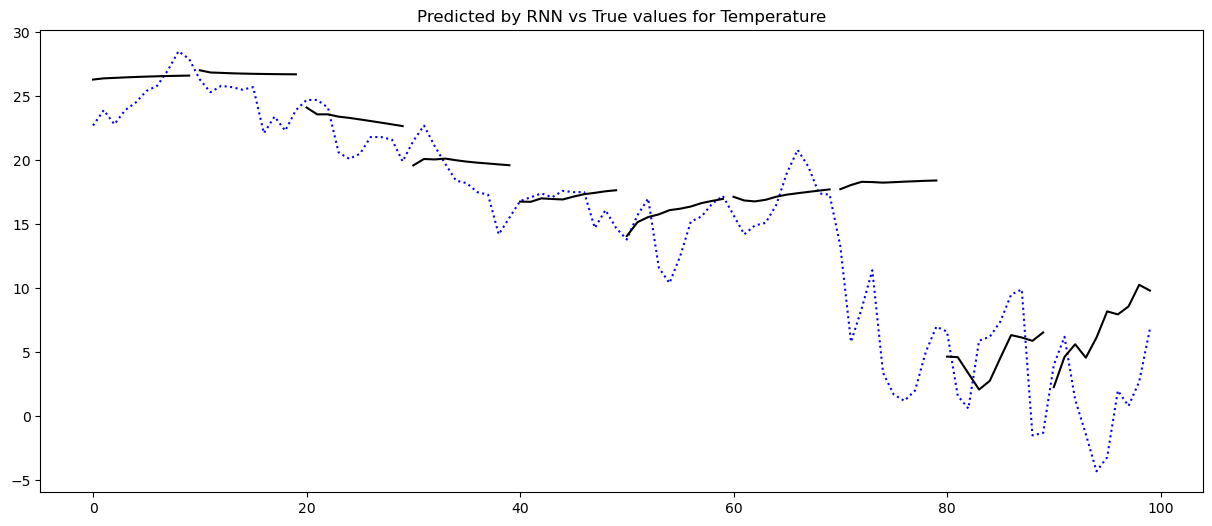

In [184]:
# for each sample in X_test_init predict 12 weeks of rianfall 
y_preds_rnn_t = []

for i in range(len(X_test_init)):
    pred = predict(X_test_init[i], 10, model_rnn_t)
    y_preds_rnn_t.append(pred)
# plot predicted and true values
n = len(y_preds_rnn_t)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(range(n), y_test,'b:', label = 'Original')
for i in range(0, n, 10):
    ax.plot(range(i, len(y_preds_rnn_t[i]) + i), y_preds_rnn_t[i],'k-', label = 'Predicted')
ax.set_title('Predicted by RNN vs True values for Temperature')